In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 37.7 MB/s 
     |████████████████████████████████| 67 kB 2.0 MB/s 
     |████████████████████████████████| 596 kB 38.3 MB/s 
     |████████████████████████████████| 6.8 MB 37.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import pandas as pd
import re
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import nltk
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
PRE_TRAINED_MODEL_NAME = "DeepPavlov/rubert-base-cased"

In [4]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [5]:
sents_data = pd.read_csv('first_data_sents.csv', dtype={'sent_index': str, 'sent_text': str, 'def': int}, sep=';')
sents_data = sents_data.rename(columns = {'def' : 'has_def'}) 

In [6]:
shuffle =  sents_data.sample(frac=1).reset_index(drop=True) 

In [7]:
sents_data = shuffle[:600]
sents_data_test = shuffle[601:700]

In [8]:
sents_data.head()

,sent_index,sent_text,has_def
0,t_192,"Слово является как вульгаризмом, так и ругател...",0
1,t_9351,И́стрия — название полуострова в Адриатическом...,1
2,t_185,В рассказе Станислава Лема «Как Эрг Самовозбуд...,0
3,t_24787,"Командное соревнование, за исключением первой ...",0
4,t_20481,Первоначально термин «фабула» имел значение — ...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


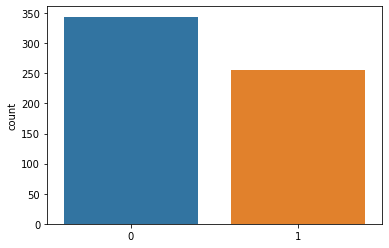

In [9]:
sns.countplot(list(sents_data['has_def']))

Датасет

In [10]:
class SentsDataset(Dataset):

  def __init__(self, sents, targets, tokenizer, max_len):
    self.sents = sents
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sents)
  
  def __getitem__(self, item):
    sent = str(self.sents[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sent,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'sent_text':sent,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [11]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
df_train, df_test = train_test_split(sents_data, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(sents_data_test, test_size=0.5, random_state=RANDOM_SEED)

In [13]:
MAX_LEN = 512

In [14]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentsDataset(
    sents=df.sent_text.to_numpy(),
    targets=df.has_def.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [15]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [16]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['sent_text', 'input_ids', 'attention_mask', 'targets'])

In [17]:
class SentsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentsClassifier, self).__init__()
    self.bert = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
  
  def forward(self, input_ids, attention_mask):
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    return output[0]

In [18]:
model = SentsClassifier(2)
model = model.to(device)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

Обучаем

In [19]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.3700898932703935 accuracy 0.8703703703703703
Val loss 0.342907987734569 accuracy 0.8979591836734693

Epoch 2/2
----------
Train loss 0.1357956215780338 accuracy 0.962962962962963
Val loss 0.38094930314192815 accuracy 0.9183673469387754

CPU times: user 4min 24s, sys: 8.32 s, total: 4min 32s
Wall time: 4min 36s


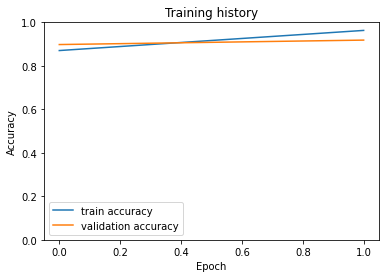

In [23]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [30]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9

Ура! Выглядит неплохо...

In [31]:
import torch.nn.functional as F

In [32]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  sent_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sent_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sent_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sent_texts, predictions, prediction_probs, real_values

In [33]:
y_sent_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [34]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92        32
           1       0.84      0.89      0.86        18

    accuracy                           0.90        50
   macro avg       0.89      0.90      0.89        50
weighted avg       0.90      0.90      0.90        50



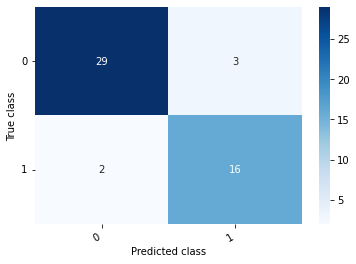

In [36]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
show_confusion_matrix(df_cm)